In [1]:
from numpy import ndarray,array, transpose
from neurotron.neurotron import Monitor
from neurotron import isa, rand, sum, zeros, ones, row, column
#from neurotron.util import repr
from neurotron import Attribute, Matrix, Field, Collab, Excite


In [10]:
from neurotron import Matrix,Field,isa

class Terminal(Attribute):
    def __init__(self,K,P=None,eta=0.5,theta=None):
        if isa(K,Collab) or isa(K,Excite):
            K,P,W,theta = K.get('K,P,W,theta')
        else:
            W = K.copy()
        self.K = K;  assert isa(K,Field)
        self.P = P;  assert isa(P,Field)
        self.W = W;  assert isa(W,Field)
        self.eta = eta
        self.theta = theta if theta is not None else 3
        
    def map(self):
        self.K.map('K: ')
        self.P.map('P: ')
        self.W.map('W: ')

    def weight(self):
        if self.P is not None:
            m,n,d,s = self.K.shape
            for k in range(m*n):
                self.W[k] = self.P[k] > self.eta
        return self.W
            
    def empower(self,v):
        m,n,d,s = self.K.shape
        E = Field(m,n,d,s)
        self.weight()               # refresh weight
        for k in range(m*n):
            V = v[self.K[k]]
            E[k] = V * self.W[k]
        return E

    def spike(self,v):              # calculate spike vectors
        m,n,d,s = self.K.shape
        S = Field(m,n,1,d)
        self.weight()               # refresh weight
        for k in range(m*n):
            V = v[self.K[k]]
            E = V * self.W[k]
            S[k] = sum(E.T) > self.theta
        return S
    
    def __call__(self,v):
        S = self.spike(v)
        M = Matrix(*S.shape[:2])
        for k in M.range():
            M[k] = max(S[k])
        return M


In [11]:
shape = (3,9,2,5)
collab=Terminal(Collab(*shape))
collab.map()

v = zeros(1,3*9);v[0] = v[1] = 1;v
E = collab.empower(v)
E.map('E: ')
S = collab.spike(v)
S.map('S: ')
collab(v)

K: +-000/0-+-003/3-+-006/6-+-009/9-+-012/C-+-015/F-+-018/I-+-021/L-+-024/O-+
   |  12   |  45   |  78   |  AB   |  DE   |  GH   |  JK   |  MN   |  PQ   |
   +-001/1-+-004/4-+-007/7-+-010/A-+-013/D-+-016/G-+-019/J-+-022/M-+-025/P-+
   |  02   |  35   |  68   |  9B   |  CE   |  FH   |  IK   |  LN   |  OQ   |
   +-002/2-+-005/5-+-008/8-+-011/B-+-014/E-+-017/H-+-020/K-+-023/N-+-026/Q-+
   |  01   |  34   |  67   |  9A   |  CD   |  FG   |  IJ   |  LM   |  OP   |
   +-------+-------+-------+-------+-------+-------+-------+-------+-------+
P: +-000/0-+-003/3-+-006/6-+-009/9-+-012/C-+-015/F-+-018/I-+-021/L-+-024/O-+
   |  11   |  11   |  11   |  11   |  11   |  11   |  11   |  11   |  11   |
   +-001/1-+-004/4-+-007/7-+-010/A-+-013/D-+-016/G-+-019/J-+-022/M-+-025/P-+
   |  11   |  11   |  11   |  11   |  11   |  11   |  11   |  11   |  11   |
   +-002/2-+-005/5-+-008/8-+-011/B-+-014/E-+-017/H-+-020/K-+-023/N-+-026/Q-+
   |  11   |  11   |  11   |  11   |  11   |  11   |  11   |  11   |  11   |

[1 0 0 0 0 0 0 0 0; 1 0 0 0 0 0 0 0 0; 1 0 0 0 0 0 0 0 0]

In [12]:
#=============================================================================================
# tokenizer
#=============================================================================================


token = {'Mary': [1,0,0,0,0,0,0,1,1],
         'John': [0,1,0,0,0,0,0,1,1],
         'likes':[0,0,1,0,0,0,0,1,1],
         'to':   [0,0,0,1,0,0,0,1,1],
         'sing': [0,0,0,0,1,0,0,1,1],
         'dance':[0,0,0,0,0,1,0,1,1],
         '.':    [0,0,0,0,0,0,1,1,1],
        }

excite = Excite(*shape[:2],token)
excite=Terminal(Excite(*shape,token))
excite.map()


K: +--000/0--+--003/3--+--006/6--+--009/9--+--012/C--+--015/F--+--018/I--+--021/L--+--024/O--+
   |012345678|012345678|012345678|012345678|012345678|012345678|012345678|012345678|012345678|
   |000000000|000000000|000000000|000000000|000000000|000000000|000000000|012345678|012345678|
   |000000000|000000000|000000000|000000000|000000000|000000000|000000000|012345678|012345678|
   |000000000|000000000|000000000|000000000|000000000|000000000|000000000|012345678|012345678|
   |000000000|000000000|000000000|000000000|000000000|000000000|000000000|012345678|012345678|
   |000000000|000000000|000000000|000000000|000000000|000000000|000000000|012345678|012345678|
   |000000000|000000000|000000000|000000000|000000000|000000000|000000000|012345678|012345678|
   +--001/1--+--004/4--+--007/7--+--010/A--+--013/D--+--016/G--+--019/J--+--022/M--+--025/P--+
   |012345678|012345678|012345678|012345678|012345678|012345678|012345678|012345678|012345678|
   |000000000|000000000|000000000|000000000|000000

In [8]:
#=========================================================================
# class Token
#=========================================================================

class Token(dict):
    def __init__(self,arg=None):
        self.dict = arg if arg is not None else {}
    def __getitem__(self,key):
        return self.dict[key]
        
#=========================================================================
# class Out
#=========================================================================

class Out:
    def __init__(self,cluster,i,j,tag):
        self.cluster = cluster
        self.i = i
        self.j = j
        self.tag = tag

    def out(self):
        data = self.cluster.get(self.tag)
        return data[self.i,self.j]

#=========================================================================
# class Cell
#=========================================================================

class Cell(Attribute):
    def __init__(self,cluster,i,j):
        """
        class Cell: access state attributes of cells[i,j]
        >>> cell = Cell(Cells(),1,1)
        >>> cell.u = 1
        """
        tags = ['u','q','d','b','x','y','s','l']
        for tag in tags:
            self.set(tag,Out(cluster,i,j,tag.upper()))
        self.predict = None

    def state(self):
        tags = ['b','d','l','q','s','u','x','y']
        dict = {}
        for tag in tags:
            dict[tag] = self.get(tag).out()
        return dict

#=========================================================================
# class Cluster
#=========================================================================

class Cluster(Attribute):
    verbose = 0
    def __init__(self,m=4,n=10,d=2,s=5,f=7):
        self.shape = (m,n,d,s)
        self.sizes = (f,n*m)
        self.cdx = Matrix(range(m*n))     # access context vector
        self.fdx = m*n+Matrix(range(f))   # access feedforward vector
        
        self.k = Matrix(range(n*m))
        self.eta = 0.5
        self.theta = 3
        self.delta = (0.1,0.1)
        
        self.K = Field(m,n,d,s)           # prediction indices
        self.P = Field(m,n,d,s)           # prediction permanences
        self.W = Field(m,n,d,s)           # prediction weights
        self.I = Field(m,n,d,s)           # learning increment
        self.F = Field(m,n,1,f)           # excitation weights
        self.G = Field(m,n,1,m-1)         # collaboration weights
        
        self.U = Matrix(m,n)
        self.Q = Matrix(m,n)
        self.D = Matrix(m,n)
        self.B = Matrix(m,n)
        self.X = Matrix(m,n)
        self.Y = Matrix(m,n)
        self.S = Matrix(m,n)
        self.L = Matrix(m,n)

    #def __zeros(self,d,s):
    #    return [[0 for j in range(s)] for i in range(d)]
    
    #def __tensor(self,m,n,d,s):
    #    return [[self.zeros(d,s) for j in range(n)] for i in range(m)]

    def range(self):
        return range(self.sizes[1])
        
    def split(self,y):    # split y int context c and feedforward f
        """
        >>> cells = Cluster(3,4,2,5,7)
        >>> y = row([1,1,1,0,0,0,1,1,1,0,0,0],[1,0,1,0,1,0,1])
        >>> cells.split(y)
        ([1 1 1 0 0 0 1 1 1 0 0 0],[1 0 1 0 1 0 1])
        """
        return (y[self.cdx],y[self.fdx])
        
    def kappa(self,i,j=None):
        """
        self.kappa():  convert matrix indices to linear index or vice versa
        >>> o = Cluster(m=4,n=10)
        >>> k = o.kappa(i:=1,j:=3)  # k = i+j*m 
        13
        >>> ij = o.kappa(k:=13)    # i = k%m, j = k//m
        (1,3)
        """

        m,n,d,s = self.shape
        if j is None:
            k = i
            return (k%m,k//m)
        else:
            return i + j*m

    def state(self,i,j):
        tags = ['B','D','L','Q','S','U','X','Y']
        s = Matrix(1,len(tags))
        for k in range(len(tags)):
            s[k] = self.get(tags[k])[i,j]
        return s

    def initG(self):
        m,n,d,s = self.shape
        for i in range(m):
            for j in range(n):
                g = []
                for nu in range(m):
                    k = self.kappa(nu,j)
                    if nu != i: g.append(k)
                self.G[i,j] = Matrix(g)

    def initK(self):
        m,n,d,s = self.shape
        self.K.set(rand((m*d,n*s),m*n))

    def initP(self):
        m,n,d,s = self.shape
        Q = 20                          # quantizing constant
        self.P.set((1+rand((m*d,n*s),Q))/Q)

    def initF(self,f=(7,4)):            # init pooler
        m,n,d,s = self.shape
        ft,fs = f                       # ft: total bits, fs: sparse bits
        self.F = Field(m,n,1,ft)        # excitation weights
        tokens = {}
        for j in range(n):
            while True:
                w = [0 for k in range(ft)]
                for k in range(fs):
                    w[rand(ft)] = 1
                if sum(w) == fs:
                    key = ''
                    for k in range(ft):
                        key += '1' if w[k] else '0'
                    if key in tokens:
                        continue
                    tokens[key] = True
                    break
            for i in range(m):        
                self.F[i,j] = Matrix(w)

    def init(self):
        self.initP()
        self.initK()
        self.initG()
        self.initF()
        return self

    def smap(self,label=''):
        m,n,d,s = self.shape
        S = Field(m,n,1,8)
        for k in range(m*n):
            S[k] = self.state(*self.kappa(k))
        S.smap(label)

    def map(self):
        self.K.imap('K: ')     # Map(self).Kmap()
        self.P.vmap('P: ')
        self.W.imap('W: ')
        self.G.imap('G: ')

    def stimu(self,y):
        c,f = self.split(y)
        for k in self.range():
            e = f * self.F[k]
            self.U[k] = (e.sum() >= 3)
        return y

    def react(self,y):
        self.Y = self.U * self.X
        self.L = self.X * self.Y
        for k in self.range():
            if self.L[k]:
                _Pij = self.P[k]
                self.P[k] += self.I[k]
                self.P[k] = max(0,min(self.P[k],1))
                if self.verbose > 0:
                    print('learn P[%g]:' % k,_Pij,'=>',self.P[k])
        y[self.k] = self.Y
        return y

    def depress(self,y):
        M,N = self.sizes
        for k in range(N):
            e = y[self.G[k]]       # collaboration empowerment
            self.D[k] = (e.sum() > 0)
            self.L[k] = 0
            #print('D[%g,%g]:' % (i,j),self.D[i][j])
        return y

    def excite(self,y):
        self.Q = self.U.copy() 
        return y

    def burst(self,y):
        M,N = self.sizes;
        for k in range(N):
            self.B[k] = int(not self.D[k] and self.Q[k])
            self.Y[k] = int(self.Y[k] or self.B[k])
            y[k] = self.Y[k]
        return y

    def predict(self,y):
        M,N = self.sizes;  c = y[:N];  f = y[N:N+M]
        for k in range(N):
            K = self.K[k]
            #print('##### K:',K,'type:',type(K),'K[0,0]:',K[0,0],type(K[0,0]))
            P = self.P[k]
            self.W[k] = W = (P >= self.eta)
            V = Matrix(c)[K]
            E = W*V
            #print('##### E:',E,'sum(E.T):',sum(E.T))
            spike = sum(E.T) >= self.theta
            #print('##### spike:',spike)
            
            self.S[k] = max(spike)
            #print('V:',V,'W:',W,'E:',E,'spike:',spike)
            self.X[k] = self.S[k]
            if self.S[k]:
                pdelta,ndelta = self.delta
                self.I[k] = 2*pdelta*V - ndelta
        return y

    def relax(self,y):
        M,N = self.sizes
        m,n,d,s = self.shape
        c = y[:N];  f = y[N:N+M]; Z = zeros(m,n)
        self.set('U,Q,D,B,Y,S',(Z,Z,Z,Z,Z,Z))

        for k in range(N):
            y[k] = self.Y[k]
        return y

    def clear(self,M):
        m,n,d,s = self.shape
        M = Matrix(m,n)
        
    def idle(self):
        clear(self.B);  clear(self.D);  clear(self.L);  clear(self.Q)
        clear(self.S);  clear(self.U);  clear(self.X);  clear(self.Y)
        for k in range(self.sizes[1]):
            y[k] = self.Y[k]
        return y

    def plot(self,mon,subplot=0,title=None):
        m,n,d,s = self.shape
        for i in range(m):
            for j in range(n):
                cell = Cell(self,i,j)
                mon(cell,i+subplot*(m+1),j)
        if title is not None:
            mon.title(title)

    def apply(self,y,tag='',log=None,all=None):
        m,n,d,s = self.shape
        y = self.stimu(y);
        prefix = tag + ' - ' if tag != '' else ''
        if log is not None:
            print('stimu ...');  self.smap()
        if all is not None:
            mon = Monitor(2*m+1,n); 
            cells.plot(mon,0);  mon.title(prefix+'stimu')

        y = self.react(y);
        if log is not None:
            print('ract ...');  self.smap()
        if all is not None:
            cells.plot(mon,1);  mon.xlabel(n/2-0.5,prefix+'react')
        else:
            mon = Monitor(2*m+1,n); 
            cells.plot(mon,0);  mon.title(prefix+'react')
        
        y = cells.depress(y);
        if log is not None:
            print('depress ...');  self.smap()
        if all is not None:
            mon = Monitor(2*m+1,n); 
            cells.plot(mon,0);  mon.title(prefix+'depress')
        
        y = cells.excite(y);
        if log is not None:
            print('excite ...');   self.smap()
        if all is not None:
            cells.plot(mon,1);  mon.xlabel(n/2-0.5,prefix+'excite')

        y = cells.burst(y);
        if log is not None:
            print('burst ...');    self.smap()
        if all is not None:
            mon = Monitor(2*m+1,n); 
            cells.plot(mon,0);  mon.title(prefix+'burst')
        
        y = cells.predict(y);  
        if log is not None:
            print('predict ...');  self.smap()
        if all is not None:
            cells.plot(mon,1);  mon.xlabel(n/2-0.5,prefix+'predict')
        else:
            cells.plot(mon,1);  mon.xlabel(n/2-0.5,prefix+'predict')
        
        y = cells.relax(y);
        if log is not None:
            print('relax ...');    self.smap()
        if all is not None:
            mon = Monitor(2*m+1,n); 
            cells.plot(mon,0);  mon.title(prefix+'relax')
        return y        

#==========================================================================================================
# tokenizer
#==========================================================================================================


token = Token({'Mary': [1,0,0,0,0,0,0,1,1],
               'John': [0,1,0,0,0,0,0,1,1],
               'likes':[0,0,1,0,0,0,0,1,1],
               'to':   [0,0,0,1,0,0,0,1,1],
               'sing': [0,0,0,0,1,0,0,1,1],
               'dance':[0,0,0,0,0,1,0,1,1],
               '.':    [0,0,0,0,0,0,1,1,1],
               })


c: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
f: [1 0 0 0 0 0 0]


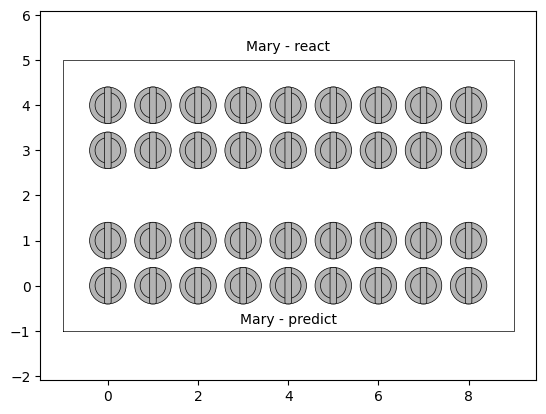

In [9]:
shape = (2,9,2,5); m,n,d,s = shape
cells = Cluster(*shape).init()
y = row(zeros(1,m*n),token['Mary'])
print('c:',y[cells.cdx])
print('f:',y[cells.fdx])
#y = cells.stimu(y)
y = cells.apply(y,'Mary')


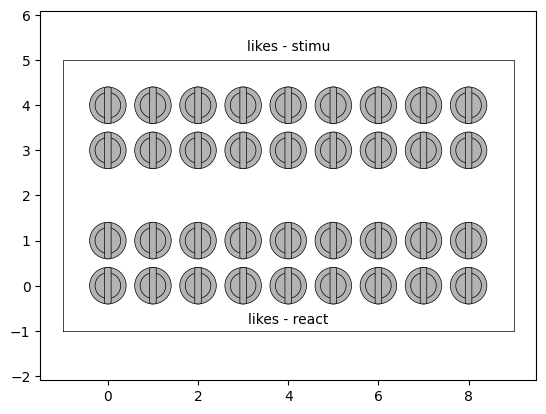

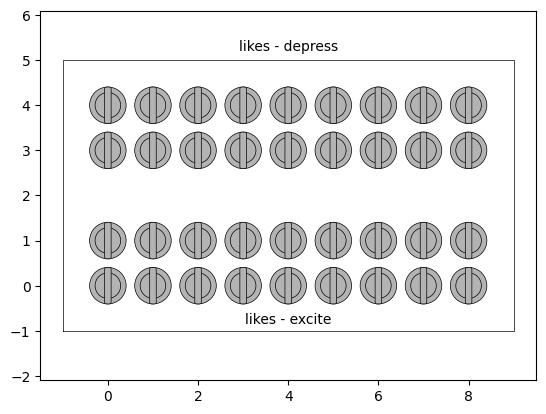

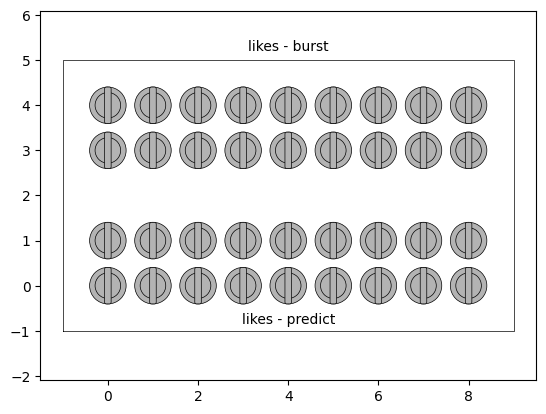

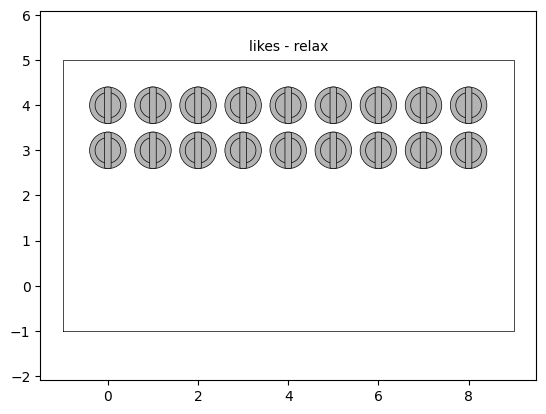

In [10]:
y = row(zeros(1,m*n),token['likes'])
y = cells.apply(y,'likes',all=True)



In [11]:
class Collab:  # to manage collaboration topology
    """
    >>> shape = (3,9,2,5)
    >>> Collab(*shape)
    Collab(3,9)
    """
    def __init__(self,m,n,dummy1=0,dummy2=0):
        self.shape = (m,n)
        self.init()
        
    def __str__(self):
        return 'Collab(%g,%g)' % self.shape
        
    def __repr__(self):
        return self.__str__()

    def _Kij(self,i,j):
        m,n = self.shape
        Kij = Matrix(1,m-1)
        s = 0
        for l in range(m):
            if l != i:
                Kij[s] = l + m*j;  s += 1 
        return Kij
        
    def init(self):
        m,n = self.shape
        self.K = Field(m,n,1,m-1)
        self.P = Field(m,n,1,m-1)
        self.W = Field(m,n,1,m-1)
        for i in range(m):
            for j in range(n):
                self.K[i,j] = self._Kij(i,j)
                self.P[i,j] = ones(1,m-1)
                self.W[i,j] = ones(1,m-1)

    def map(self):
        self.K.imap('K: ')
        self.P.vmap('P: ')
        self.W.imap('W: ')
        

In [12]:
shape=(3,4,2,5)
C=Collab(*shape)
C.map()

K: +-000/0-+-003/3-+-006/6-+-009/9-+
   |  12   |  45   |  78   |  AB   |
   +-001/1-+-004/4-+-007/7-+-010/A-+
   |  02   |  35   |  68   |  9B   |
   +-002/2-+-005/5-+-008/8-+-011/B-+
   |  01   |  34   |  67   |  9A   |
   +-------+-------+-------+-------+
P: +-000/0-+-003/3-+-006/6-+-009/9-+
   |  11   |  11   |  11   |  11   |
   +-001/1-+-004/4-+-007/7-+-010/A-+
   |  11   |  11   |  11   |  11   |
   +-002/2-+-005/5-+-008/8-+-011/B-+
   |  11   |  11   |  11   |  11   |
   +-------+-------+-------+-------+
W: +-000/0-+-003/3-+-006/6-+-009/9-+
   |  11   |  11   |  11   |  11   |
   +-001/1-+-004/4-+-007/7-+-010/A-+
   |  11   |  11   |  11   |  11   |
   +-002/2-+-005/5-+-008/8-+-011/B-+
   |  11   |  11   |  11   |  11   |
   +-------+-------+-------+-------+


In [13]:
class Terminal:
    def __init__(m=1,n=3,d=1,s=5):
        self.shape = (m,n,d,s)
        self.K = Field(m,n,d,s)
        self.P = Field(m,n,d,s)
        self.W = Field(m,n,d,s)
        self.eta = 0.5
        self.theta = s//2
        self.delta = (0.1,0.1)

    def setup(self,arg):
        """
        .setup(Token(...))   # setup by given token
        """